In [1]:
import pathlib
import pickle
import random
import json
import joblib
import torchvision
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm import tqdm
from sklearn import preprocessing

plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
BASE_DIR = pathlib.Path().resolve().parent

DATA_DIR = BASE_DIR / 'data'

EXPORTS_DIR = DATA_DIR / 'exports'
XRAY_LUNG_CLF_DIR = DATA_DIR / 'xray_lung_clf'

TRAIN_DATA_PATH = XRAY_LUNG_CLF_DIR / 'train'
TEST_DATA_PATH = XRAY_LUNG_CLF_DIR / 'test'

TRAIN_ANNOTATIONS_PATH = XRAY_LUNG_CLF_DIR / 'train_annotations.json'
TEST_ANNOTATIONS_PATH = XRAY_LUNG_CLF_DIR / 'test_annotations.json'

EXPORTS_LUNGCLF_DIR = EXPORTS_DIR / 'xray_lung_clf'

EXPORTS_TRAIN_DATA_PATH = EXPORTS_LUNGCLF_DIR / 'train_X.z'
EXPORTS_TEST_DATA_PATH = EXPORTS_LUNGCLF_DIR / 'test_X.z'

EXPORTS_TRAIN_LABELS_PATH = EXPORTS_LUNGCLF_DIR / 'train_Y.z'
EXPORTS_TEST_LABELS_PATH = EXPORTS_LUNGCLF_DIR / 'test_Y.z'

EXPORTS_LUNGCLF_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
def show_images(nrows: int = 5, ncols: int = 5):
    '''
    loads matrix of sample images
    '''
    
    # load all paths
    all_paths = []
    
    for path in TRAIN_DATA_PATH.glob('*'):
        all_paths.append(str(path))
    
    # select subsample of paths
    img_paths = random.choices(all_paths, k=nrows * ncols)
    
    # create array of images
    fig, axs = plt.subplots(nrows, ncols)
    for i in range(nrows):
        for j in range(ncols):
            img_path = img_paths[i * nrows + j]
            img = mpimg.imread(img_path)
            axs[i, j].imshow(img)

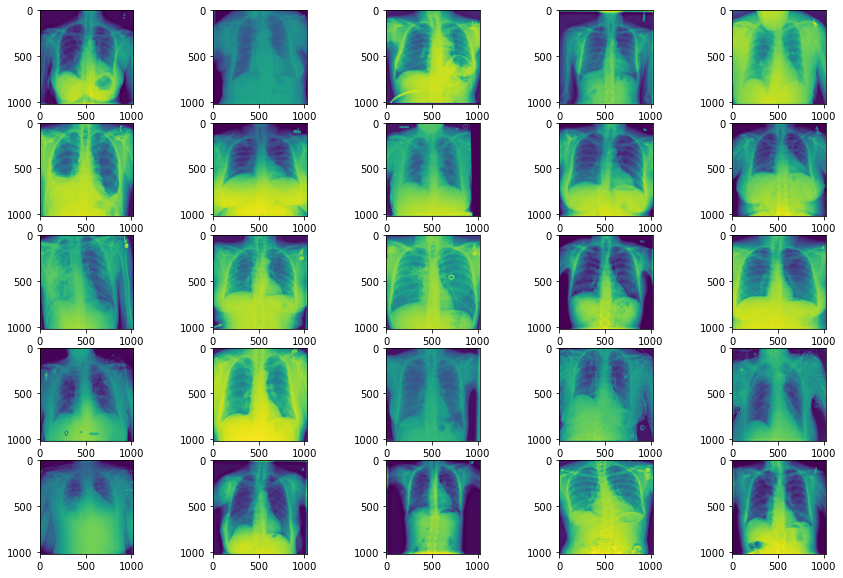

In [4]:
show_images()

# Create Datasets

In [5]:
def check_matching_filenames(ANNOTATIONS_PATH, DATA_PATH):
    '''
    for given file paths, check if image and label file names match
    '''
    
    # load and sort annotations
    with open(str(ANNOTATIONS_PATH)) as f:
        annotations = json.load(f)

    annotations = sorted(annotations, key=lambda d: d['file_name']) 
    
    # check that order in list of paths to images matches order in annotations file
    all_paths = []
    
    for i, path in enumerate(sorted(DATA_PATH.glob('*.png'))):
        all_paths.append(pathlib.Path(path))
        try:
            assert pathlib.Path(path).name == annotations[i]['file_name']
        except:
            print(f'No match of file names at index {i}')
    
    if DATA_PATH.name.startswith('train'):
        data_type = 'train'
    elif DATA_PATH.name.startswith('test'):
        data_type = 'test'
    else: 
        data_type = ''
    
    print(f'succesfully matched {data_type} data')
        
    return annotations, all_paths

In [6]:
def create_image_tensor(paths):   
    '''
    Images in folder come in all shapes and sizes. Convert all into images w/ 1 channel. 
    '''

    images_in_tensor = []

    for i in tqdm(range(len(paths))):

        # read into array
        img = mpimg.imread(str(paths[i]))

        # mean out different channels if C>1
        try:
            img = img.mean(axis=2)
        except:
            pass

        # Read into tensors and add dummy channel C=1
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor[None, :, :]

        # Reshape
        image_transformation = torchvision.transforms.Compose([torchvision.transforms.Resize((256,256))])
        reshaped_img_tensor = image_transformation(img_tensor)

        # Add to list
        images_in_tensor.append(reshaped_img_tensor)

    # stack along new dimension, cat along existing dimension
    data_tensor = torch.stack(images_in_tensor, dim = 0)
    
    return data_tensor

In [7]:
def count_diseases(annotations):
    
    '''
    Find unique diseases.
    '''

    diseases = [ind['syms'] for ind in annotations]
    flat_diseases = [item for sublist in diseases for item in sublist]
    diseases = list(set(flat_diseases))
    num_diseases = len(diseases)
    
    return num_diseases, diseases

In [8]:
def create_one_hot(annotations, encoder=None):
    '''
    Create OneHot vectors
    '''
    
    y_onehot = []
    num_diseases, diseases = count_diseases(annotations)
    encoder = preprocessing.LabelEncoder()
    encoder.fit(diseases)
    
    for ind in tqdm(annotations):
        y = encoder.transform(ind['syms'])
        y_onehot_list = [1 if i in y else 0 for i in range(num_diseases)]
        y_onehot_tensor = torch.FloatTensor(y_onehot_list)
        y_onehot.append(y_onehot_tensor)
    
    y = torch.stack(y_onehot, axis=0)
    print(y.shape)
    
    return y, encoder

In [9]:
train_annotations, train_paths = check_matching_filenames(TRAIN_ANNOTATIONS_PATH, TRAIN_DATA_PATH)
test_annotations, test_paths = check_matching_filenames(TEST_ANNOTATIONS_PATH, TEST_DATA_PATH)

succesfully matched train data
succesfully matched test data


In [10]:
train_X = create_image_tensor(train_paths)
test_X = create_image_tensor(test_paths)

100%|██████████| 553/553 [00:16<00:00, 33.78it/s]


In [11]:
train_Y, encoder = create_one_hot(train_annotations, encoder=None)
test_Y, _ = create_one_hot(test_annotations, encoder=encoder)

100%|██████████| 3025/3025 [00:00<00:00, 6773.18it/s]


torch.Size([3025, 13])


100%|██████████| 553/553 [00:00<00:00, 6527.12it/s]

torch.Size([553, 13])


In [12]:
# Testing cell
assert train_X.shape[0] == train_Y.shape[0]
assert train_X.shape[1] == test_X.shape[1]
assert train_X.shape[2] == test_X.shape[2]
assert train_X.shape[3] == test_X.shape[3]

## Print summary & save data (pickled)

In [13]:
print(f'There are {train_X.shape[0]} training examples')
print(f'There are {test_X.shape[0]} training examples')
print(f'The images have {train_X.shape[1]} channels')
print(f'The images are of size {train_X.shape[2]} x {train_X.shape[3]} channels')
print(f'There are {train_Y.shape[1]} different diseases')
print(f'shape of the data is: {train_X.shape}')
print(f'type of the data is: {type(train_X)}')

There are 3025 training examples
There are 553 training examples
The images have 1 channels
The images are of size 256 x 256 channels
There are 13 different diseases
shape of the data is: torch.Size([3025, 1, 256, 256])
type of the data is: <class 'torch.Tensor'>


In [14]:
with open(EXPORTS_TRAIN_DATA_PATH, 'wb') as f:
    joblib.dump(train_X.numpy(), f)

with open(EXPORTS_TEST_DATA_PATH, 'wb') as f:
    joblib.dump(test_X.numpy(), f)

with open(EXPORTS_TRAIN_LABELS_PATH, 'wb') as f:
    joblib.dump(train_Y.numpy(), f)
    
with open(EXPORTS_TEST_LABELS_PATH, 'wb') as f:
    joblib.dump(test_Y.numpy(), f)

# Test

In [15]:
with open(EXPORTS_TRAIN_DATA_PATH, 'rb') as f:
    X_train = joblib.load(f)

with open(EXPORTS_TEST_DATA_PATH, 'rb') as f:
    X_test = joblib.load(f)

with open(EXPORTS_TRAIN_LABELS_PATH, 'rb') as f:
    Y_train = joblib.load(f)
    
with open(EXPORTS_TEST_LABELS_PATH, 'rb') as f:
    Y_test =joblib.load(f)

In [16]:
assert X_train.shape == train_X.shape
assert X_test.shape == test_X.shape
assert Y_train.shape == train_Y.shape
assert Y_test.shape == test_Y.shape